In [55]:
! mkdir ~/.kaggle
! touch ~/.kaggle/kaggle.json

api_token = {"username": "your-username",
             "key": "your-api-key"}

import json

with open("/root/.kaggle/kaggle.json", "w") as file:
    json.dump(api_token, file)

! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets download -d giannisgeorgiou/fish-species

! unzip fish-species.zip

fish-species.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  fish-species.zip
replace Species/Test_Set/Anthias anthias/anthias_anthias-1700.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [56]:
# Imports cell

from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import random
import os
from shutil import copyfile, rmtree
from pathlib import Path
from glob import glob
import itertools
import warnings

warnings.filterwarnings("ignore")

In [57]:
# Directory of all 20 classes
INPUT_CLASSES_DIR = "./Species/Training_Set/"
folders = glob(INPUT_CLASSES_DIR + '/*')
n_classes = len(folders)

# Number of samples per class for training
TRAIN_SAMPLE_SIZE = 200

# Number of samples per class for testing (sum of both must be less than 1700)
TEST_SAMPLE_SIZE = 20

In [58]:
# Copy all images to use for training and testing

test_root = "./test"
train_root = "./train"

rmtree(train_root, ignore_errors=True)
rmtree(test_root, ignore_errors=True)

for dirname in folders:
    current_subfolder = dirname.split("/")[-1]
    folder_sample = random.sample(glob(dirname + "/*"), TRAIN_SAMPLE_SIZE + TEST_SAMPLE_SIZE)
    Path(f"{test_root}/{current_subfolder}").mkdir(parents=True, exist_ok=True)
    Path(f"{train_root}/{current_subfolder}").mkdir(parents=True, exist_ok=True)
    train_filenames = folder_sample[:TRAIN_SAMPLE_SIZE]
    for f in train_filenames:
        copyfile(f, f"{train_root}/{current_subfolder}/{f.split('/')[-1]}")
    test_filenames = folder_sample[TRAIN_SAMPLE_SIZE:]
    for f in test_filenames:
        copyfile(f, f"{test_root}/{current_subfolder}/{f.split('/')[-1]}")

train_files = glob(train_root + "/*/*.jp*g")
test_files = glob(test_root + "/*/*.jp*g")

print(len(train_files))
print(len(test_files))

4000
400


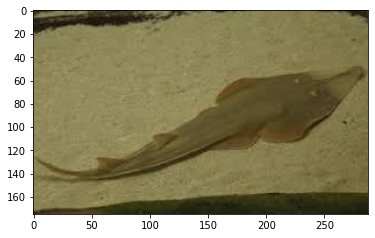

In [59]:
# Plot a random image
plt.imshow(image.load_img(np.random.choice(train_files)))

In [66]:
# ResNet50 network
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

image_size = [200, 200]
resnet = ResNet50(input_shape=image_size + [3], weights="imagenet", include_top=False)

# Make ResNet weights non trainable
for layer in resnet.layers:
    layer.trainable = False

# Print summary
# resnet.summary()

In [67]:
# Chain a neural network at the end
x = Flatten()(resnet.output)
prediction = Dense(n_classes, activation="softmax")(x)

# Full model using the Functional API
model = Model(inputs=resnet.input, outputs=prediction)

# Print summary
# model.summary()

In [68]:
# Compile the model using appropriate loss and optimizer
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam", metrics=["accuracy"])

In [69]:
# Create ImageDataGenerator objects for training and testing

batch_size = 128

train_gen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

val_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_generator = train_gen.flow_from_directory(
    train_root,
    target_size=image_size,
    shuffle=True,
    batch_size=batch_size,
    class_mode="sparse"
)

valid_generator = val_gen.flow_from_directory(
    test_root,
    target_size=image_size,
    shuffle=False,
    batch_size=batch_size,
    class_mode="sparse"
)

Found 4000 images belonging to 20 classes.
Found 400 images belonging to 20 classes.


In [70]:
# Translate labels into species

test_gen = val_gen.flow_from_directory(
    test_root, 
    target_size=image_size
)

labels = [None] * len(test_gen.class_indices)
for k, v in test_gen.class_indices.items():
    labels[v] = k

Found 400 images belonging to 20 classes.


In [71]:
# Fit the model

epochs = 20
callback = EarlyStopping(monitor="loss", patience=3)

history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[callback]
)

Epoch 1/20
32/32 [==============================] - 77s 2s/step - loss: 15.0407 - accuracy: 0.4757 - val_loss: 3.3423 - val_accuracy: 0.7775
Epoch 2/20
32/32 [==============================] - 69s 2s/step - loss: 2.7004 - accuracy: 0.8002 - val_loss: 1.9916 - val_accuracy: 0.8500
Epoch 3/20
32/32 [==============================] - 67s 2s/step - loss: 1.7500 - accuracy: 0.8525 - val_loss: 1.9986 - val_accuracy: 0.8375
Epoch 4/20
32/32 [==============================] - 66s 2s/step - loss: 1.5009 - accuracy: 0.8810 - val_loss: 1.6863 - val_accuracy: 0.8800
Epoch 5/20
32/32 [==============================] - 66s 2s/step - loss: 1.3584 - accuracy: 0.8857 - val_loss: 1.9755 - val_accuracy: 0.8725
Epoch 6/20
32/32 [==============================] - 65s 2s/step - loss: 1.2168 - accuracy: 0.8907 - val_loss: 2.0156 - val_accuracy: 0.8775
Epoch 7/20
32/32 [==============================] - 64s 2s/step - loss: 1.1961 - accuracy: 0.9018 - val_loss: 1.9453 - val_accuracy: 0.8925
Epoch 8/20
32/32 [=

In [73]:
# Plot training loss and accuracy

resnet_loss = history.history["loss"]
resnet_val_loss = history.history["val_loss"]
resnet_accuracy = history.history["accuracy"]
resnet_val_accuracy = history.history["val_accuracy"]

In [76]:
# Evaluate the model on test set

model.evaluate(valid_generator)
preds_resnet = model.predict(valid_generator)

4/4 [==============================] - 4s 734ms/step - loss: 2.2226 - accuracy: 0.9125


In [77]:
# Using VGG19 instead of ResNet50 

# VGG19 network
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
vgg19 = VGG19(input_shape=image_size + [3], weights="imagenet", include_top=False)

# Make weights non trainable
for layer in vgg19.layers:
    layer.trainable = False

# Chain a neural network at the end
x = Flatten()(vgg19.output)
prediction = Dense(n_classes, activation="softmax")(x)

# Full model using the Functional API
model = Model(inputs=vgg19.input, outputs=prediction)

# model.summary()

In [78]:
# Compile the model using appropriate loss and optimizer
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam", metrics=["accuracy"])

# Create ImageDataGenerator objects for training and testing
batch_size = 128

train_gen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

val_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_generator = train_gen.flow_from_directory(
    train_root,
    target_size=image_size,
    shuffle=True,
    batch_size=batch_size,
    class_mode="sparse",
)

valid_generator = val_gen.flow_from_directory(
    test_root,
    target_size=image_size,
    shuffle=False,
    batch_size=batch_size,
    class_mode="sparse",
)

test_gen = val_gen.flow_from_directory(
    test_root, 
    target_size=image_size
)

Found 4000 images belonging to 20 classes.
Found 400 images belonging to 20 classes.
Found 400 images belonging to 20 classes.


In [79]:
# Fit the model

epochs = 20
callback = EarlyStopping(monitor="loss", patience=3)

history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[callback]
)

Epoch 1/20
32/32 [==============================] - 76s 2s/step - loss: 11.0020 - accuracy: 0.4565 - val_loss: 5.5712 - val_accuracy: 0.7300
Epoch 2/20
32/32 [==============================] - 72s 2s/step - loss: 4.3752 - accuracy: 0.7308 - val_loss: 4.0892 - val_accuracy: 0.7850
Epoch 3/20
32/32 [==============================] - 71s 2s/step - loss: 3.4452 - accuracy: 0.7795 - val_loss: 4.2650 - val_accuracy: 0.7925
Epoch 4/20
32/32 [==============================] - 71s 2s/step - loss: 2.9185 - accuracy: 0.8130 - val_loss: 2.8743 - val_accuracy: 0.8225
Epoch 5/20
32/32 [==============================] - 70s 2s/step - loss: 2.8170 - accuracy: 0.8250 - val_loss: 3.7647 - val_accuracy: 0.8075
Epoch 6/20
32/32 [==============================] - 70s 2s/step - loss: 2.2666 - accuracy: 0.8562 - val_loss: 4.3647 - val_accuracy: 0.8025
Epoch 7/20
32/32 [==============================] - 70s 2s/step - loss: 2.1174 - accuracy: 0.8655 - val_loss: 3.6048 - val_accuracy: 0.8525
Epoch 8/20
32/32 [=

In [80]:
# Plot training loss and accuracy

vgg_loss = history.history["loss"]
vgg_val_loss = history.history["val_loss"]
vgg_accuracy = history.history["accuracy"]
vgg_val_accuracy = history.history["val_accuracy"]

In [81]:
# Evaluate the model on test set and predict
model.evaluate(valid_generator)
preds_vgg = model.predict(valid_generator)

4/4 [==============================] - 4s 862ms/step - loss: 3.6315 - accuracy: 0.8750


In [84]:
# Using InceptionV3

# Xception network
from tensorflow.keras.applications.xception import Xception, preprocess_input
xception = Xception(input_shape=image_size + [3], weights="imagenet", include_top=False)

# Make weights non trainable
for layer in xception.layers:
    layer.trainable = False

# Chain a neural network at the end
x = Flatten()(xception.output)
prediction = Dense(n_classes, activation="softmax")(x)

# Full model using the Functional API
model = Model(inputs=xception.input, outputs=prediction)

# model.summary()

In [85]:
# Compile the model using appropriate loss and optimizer
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam", metrics=["accuracy"])

# Create ImageDataGenerator objects for training and testing
batch_size = 128

train_gen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

val_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_generator = train_gen.flow_from_directory(
    train_root,
    target_size=image_size,
    shuffle=True,
    batch_size=batch_size,
    class_mode="sparse"
)

valid_generator = val_gen.flow_from_directory(
    test_root,
    target_size=image_size,
    shuffle=False,
    batch_size=batch_size,
    class_mode="sparse"
)

test_gen = val_gen.flow_from_directory(
    test_root, 
    target_size=image_size
)

Found 4000 images belonging to 20 classes.
Found 400 images belonging to 20 classes.
Found 400 images belonging to 20 classes.


In [86]:
# Fit the model

epochs = 20
callback = EarlyStopping(monitor="loss", patience=3)

history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[callback]
)

Epoch 1/20
32/32 [==============================] - 80s 2s/step - loss: 8.2379 - accuracy: 0.4395 - val_loss: 2.0320 - val_accuracy: 0.7575
Epoch 2/20
32/32 [==============================] - 75s 2s/step - loss: 1.7252 - accuracy: 0.7577 - val_loss: 1.2955 - val_accuracy: 0.7925
Epoch 3/20
32/32 [==============================] - 71s 2s/step - loss: 1.1491 - accuracy: 0.8117 - val_loss: 1.2728 - val_accuracy: 0.8025
Epoch 4/20
32/32 [==============================] - 72s 2s/step - loss: 1.2059 - accuracy: 0.8127 - val_loss: 0.7163 - val_accuracy: 0.8700
Epoch 5/20
32/32 [==============================] - 71s 2s/step - loss: 0.8946 - accuracy: 0.8470 - val_loss: 0.9186 - val_accuracy: 0.8500
Epoch 6/20
32/32 [==============================] - 73s 2s/step - loss: 0.8171 - accuracy: 0.8605 - val_loss: 0.6144 - val_accuracy: 0.8725
Epoch 7/20
32/32 [==============================] - 71s 2s/step - loss: 0.7960 - accuracy: 0.8640 - val_loss: 0.7082 - val_accuracy: 0.8875
Epoch 8/20
32/32 [==

In [87]:
# Plot training loss and accuracy

xception_loss = history.history["loss"]
xception_val_loss = history.history["val_loss"]
xception_accuracy = history.history["accuracy"]
xception_val_accuracy = history.history["val_accuracy"]

In [88]:
# Evaluate the model on test set and predict
model.evaluate(valid_generator)
preds_xception = model.predict(valid_generator)

4/4 [==============================] - 4s 799ms/step - loss: 0.9631 - accuracy: 0.8625


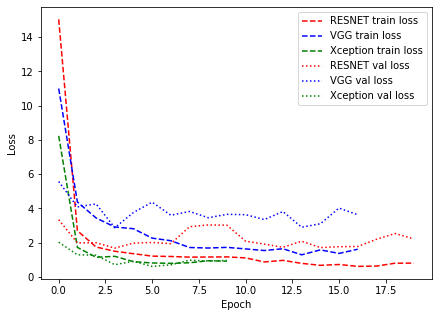

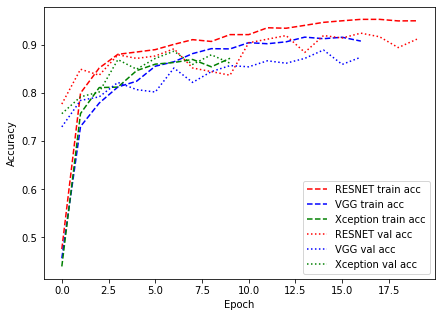

In [102]:
# Compare loss for all models

plt.figure(figsize=(7, 5))
plt.plot(resnet_loss, "--", label="RESNET train loss", c="red")
plt.plot(vgg_loss, "--", label="VGG train loss", c="blue")
plt.plot(xception_loss, "--", label="Xception train loss", c="green")
plt.plot(resnet_val_loss, ":", label="RESNET val loss", c="red")
plt.plot(vgg_val_loss, ":", label="VGG val loss", c="blue")
plt.plot(xception_val_loss, ":", label="Xception val loss", c="green")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.figure(figsize=(7, 5))
plt.plot(resnet_accuracy, "--", label="RESNET train acc", c="red")
plt.plot(vgg_accuracy, "--", label="VGG train acc", c="blue")
plt.plot(xception_accuracy, "--", label="Xception train acc", c="green")
plt.plot(resnet_val_accuracy, ":", label="RESNET val acc", c="red")
plt.plot(vgg_val_accuracy, ":", label="VGG val acc", c="blue")
plt.plot(xception_val_accuracy, ":", label="Xception val acc", c="green")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

In [138]:
# Combining all models 

preds_stacked = preds_resnet + preds_vgg + preds_xception
preds_classes = []
for i in range(preds_stacked.shape[0]):
  preds_classes.append(preds_stacked[i].argmax())
preds_classes = np.array(preds_classes)

true_classes = np.array([[i] * 20 for i in range(20)]).reshape(1, -1)[0]

print(f"Accuracy of all 3 stacked models on test set: {(true_classes == preds_classes).mean()}")

Accuracy of all 3 stacked models on test set: 0.9525


In [ ]:
### TO-DO

"""
Use VAE for dimensionality reduction and see how fish species are organised in the
latent space and also for generating new fish images. 
"""